In [102]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
# from torchsummary import summary

# from pushover import notify
# from utils import makegif
from random import randint

from IPython.display import Image
from IPython.core.display import Image, display
from PIL import Image as I

from imgaug import augmenters as iaa
from torchsummary import summary

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bs = 8

In [104]:
def augmentation(im):
    """
    image: 1, 3, n, n tensor
    
    output: num, 3, n, n tensor
    """
    transformations = [
        iaa.Crop(px=(0, 10)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # horizontally flip 50% of the images
        iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
        iaa.Noop()
    ]

    im = im.permute(1, 2, 0).numpy()
    return torch.Tensor([t(image=im) for t in transformations]).permute(0, 3, 1, 2)

In [105]:
na = 4

In [106]:
# dataset = datasets.ImageFolder(root='./data-nodules2d', transform = transforms.Compose([transforms.ToTensor()]))
dataset = datasets.CIFAR10('.', transform = transforms.Compose([transforms.ToTensor(), augmentation]), download = True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset.train_data), len(dataloader)

Files already downloaded and verified


(50000, 6250)

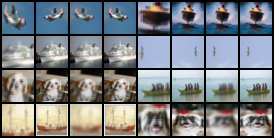

In [107]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

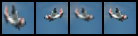

In [108]:
a = fixed_x.view(bs, na, 3, 32, 32)

save_image(a[0], 'real_image.png')
display(Image('real_image.png', width=500, unconfined=True))

### Todo: Totensor --> Numpy --> Totensor

In [109]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 512)
        
        self.conv4 = nn.Conv2d(32, 16, 3,padding = 1)
        self.conv5 = nn.Conv2d(16, 6, 3,padding = 1)
        self.conv6 = nn.Conv2d(6, 3, 3,padding = 1)

        
    def encoder(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        return x
    
    
    # TODO: Use Fc for pooling    
    def pooling(self, vectors):
        vectors = vectors.view(bs, na, 128)
        vectors = vectors[:, :na-1, :]
        return vectors.mean(dim=1)
    
    def decoder(self, vector):
        x = self.fc2(vector)
        # 1, 512 --> 1, 32, 4, 4
        x = x.reshape(-1, 32, 4, 4)
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv4(x)
        x = F.relu(x)
        
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv5(x)
        x = F.relu(x)

        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = self.conv6(x)

        x = torch.sigmoid(x)
        return x
       
        
    def forward(self,x):
        x = x.view(-1, 3, 32, 32)
        x = self.encoder(x)
        x = self.pooling(x)
        x = self.decoder(x)
        return x

net = Net()

In [110]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [111]:
# summary(net, (3, 32, 32))

In [112]:
model = Net()
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()

In [113]:
net(fixed_x).shape

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([8, 3, 32, 32])

In [114]:
def train(train_loader):
    epoch = 1
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        I_prime = model(data)
        
        I = data[:, -1, :]
        l1 = loss(I, I_prime)
        l1.backward()
        optimizer.step()
        
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), l1.item()))

In [ ]:
train(dataloader)

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train Epoch: 1 [0/50000 (0%)]	Loss: 0.071251
Train Epoch: 1 [16/50000 (0%)]	Loss: 0.053139
Train Epoch: 1 [32/50000 (0%)]	Loss: 0.065137
Train Epoch: 1 [48/50000 (0%)]	Loss: 0.067649
Train Epoch: 1 [64/50000 (0%)]	Loss: 0.043370
Train Epoch: 1 [80/50000 (0%)]	Loss: 0.059964
Train Epoch: 1 [96/50000 (0%)]	Loss: 0.064422
Train Epoch: 1 [112/50000 (0%)]	Loss: 0.059894
Train Epoch: 1 [128/50000 (0%)]	Loss: 0.063751
Train Epoch: 1 [144/50000 (0%)]	Loss: 0.069206
Train Epoch: 1 [160/50000 (0%)]	Loss: 0.076180
Train Epoch: 1 [176/50000 (0%)]	Loss: 0.049405
Train Epoch: 1 [192/50000 (0%)]	Loss: 0.066205
Train Epoch: 1 [208/50000 (0%)]	Loss: 0.066368
Train Epoch: 1 [224/50000 (0%)]	Loss: 0.059799
Train Epoch: 1 [240/50000 (0%)]	Loss: 0.066035
Train Epoch: 1 [256/50000 (1%)]	Loss: 0.052829
Train Epoch: 1 [272/50000 (1%)]	Loss: 0.068493
Train Epoch: 1 [288/50000 (1%)]	Loss: 0.056706
Train Epoch: 1 [304/50000 (1%)]	Loss: 0.054149
Train Epoch: 1 [320/50000 (1%)]	Loss: 0.074922
Train Epoch: 1 [336/5

Train Epoch: 1 [2784/50000 (6%)]	Loss: 0.026872
Train Epoch: 1 [2800/50000 (6%)]	Loss: 0.029729
Train Epoch: 1 [2816/50000 (6%)]	Loss: 0.026020
Train Epoch: 1 [2832/50000 (6%)]	Loss: 0.029689
Train Epoch: 1 [2848/50000 (6%)]	Loss: 0.043100
Train Epoch: 1 [2864/50000 (6%)]	Loss: 0.029119
Train Epoch: 1 [2880/50000 (6%)]	Loss: 0.031139
Train Epoch: 1 [2896/50000 (6%)]	Loss: 0.028822
Train Epoch: 1 [2912/50000 (6%)]	Loss: 0.020906
Train Epoch: 1 [2928/50000 (6%)]	Loss: 0.030363
Train Epoch: 1 [2944/50000 (6%)]	Loss: 0.028452
Train Epoch: 1 [2960/50000 (6%)]	Loss: 0.021983
Train Epoch: 1 [2976/50000 (6%)]	Loss: 0.030880
Train Epoch: 1 [2992/50000 (6%)]	Loss: 0.029244
Train Epoch: 1 [3008/50000 (6%)]	Loss: 0.031206
Train Epoch: 1 [3024/50000 (6%)]	Loss: 0.030471
Train Epoch: 1 [3040/50000 (6%)]	Loss: 0.036852
Train Epoch: 1 [3056/50000 (6%)]	Loss: 0.028995
Train Epoch: 1 [3072/50000 (6%)]	Loss: 0.025576
Train Epoch: 1 [3088/50000 (6%)]	Loss: 0.034962
Train Epoch: 1 [3104/50000 (6%)]	Loss: 0

Train Epoch: 1 [5504/50000 (11%)]	Loss: 0.024637
Train Epoch: 1 [5520/50000 (11%)]	Loss: 0.036060
Train Epoch: 1 [5536/50000 (11%)]	Loss: 0.022702
Train Epoch: 1 [5552/50000 (11%)]	Loss: 0.020844
Train Epoch: 1 [5568/50000 (11%)]	Loss: 0.024675
Train Epoch: 1 [5584/50000 (11%)]	Loss: 0.025800
Train Epoch: 1 [5600/50000 (11%)]	Loss: 0.030364
Train Epoch: 1 [5616/50000 (11%)]	Loss: 0.019458
Train Epoch: 1 [5632/50000 (11%)]	Loss: 0.025819
Train Epoch: 1 [5648/50000 (11%)]	Loss: 0.023362
Train Epoch: 1 [5664/50000 (11%)]	Loss: 0.031759
Train Epoch: 1 [5680/50000 (11%)]	Loss: 0.020273
Train Epoch: 1 [5696/50000 (11%)]	Loss: 0.033933
Train Epoch: 1 [5712/50000 (11%)]	Loss: 0.032210
Train Epoch: 1 [5728/50000 (11%)]	Loss: 0.036802
Train Epoch: 1 [5744/50000 (11%)]	Loss: 0.030737
Train Epoch: 1 [5760/50000 (12%)]	Loss: 0.020901
Train Epoch: 1 [5776/50000 (12%)]	Loss: 0.036477
Train Epoch: 1 [5792/50000 (12%)]	Loss: 0.033125
Train Epoch: 1 [5808/50000 (12%)]	Loss: 0.030068
Train Epoch: 1 [5824

Train Epoch: 1 [8192/50000 (16%)]	Loss: 0.019158
Train Epoch: 1 [8208/50000 (16%)]	Loss: 0.026711
Train Epoch: 1 [8224/50000 (16%)]	Loss: 0.029172
Train Epoch: 1 [8240/50000 (16%)]	Loss: 0.029475
Train Epoch: 1 [8256/50000 (17%)]	Loss: 0.021721
Train Epoch: 1 [8272/50000 (17%)]	Loss: 0.027830
Train Epoch: 1 [8288/50000 (17%)]	Loss: 0.031508
Train Epoch: 1 [8304/50000 (17%)]	Loss: 0.032932
Train Epoch: 1 [8320/50000 (17%)]	Loss: 0.030160
Train Epoch: 1 [8336/50000 (17%)]	Loss: 0.028023
Train Epoch: 1 [8352/50000 (17%)]	Loss: 0.020597
Train Epoch: 1 [8368/50000 (17%)]	Loss: 0.024754
Train Epoch: 1 [8384/50000 (17%)]	Loss: 0.020343
Train Epoch: 1 [8400/50000 (17%)]	Loss: 0.029982
Train Epoch: 1 [8416/50000 (17%)]	Loss: 0.024782
Train Epoch: 1 [8432/50000 (17%)]	Loss: 0.027498
Train Epoch: 1 [8448/50000 (17%)]	Loss: 0.023323
Train Epoch: 1 [8464/50000 (17%)]	Loss: 0.028472
Train Epoch: 1 [8480/50000 (17%)]	Loss: 0.028808
Train Epoch: 1 [8496/50000 (17%)]	Loss: 0.025099
Train Epoch: 1 [8512

Train Epoch: 1 [10880/50000 (22%)]	Loss: 0.025123
Train Epoch: 1 [10896/50000 (22%)]	Loss: 0.026107
Train Epoch: 1 [10912/50000 (22%)]	Loss: 0.026116
Train Epoch: 1 [10928/50000 (22%)]	Loss: 0.027565
Train Epoch: 1 [10944/50000 (22%)]	Loss: 0.033677
Train Epoch: 1 [10960/50000 (22%)]	Loss: 0.027319
Train Epoch: 1 [10976/50000 (22%)]	Loss: 0.026215
Train Epoch: 1 [10992/50000 (22%)]	Loss: 0.018763
Train Epoch: 1 [11008/50000 (22%)]	Loss: 0.026796
Train Epoch: 1 [11024/50000 (22%)]	Loss: 0.023312
Train Epoch: 1 [11040/50000 (22%)]	Loss: 0.024801
Train Epoch: 1 [11056/50000 (22%)]	Loss: 0.022815
Train Epoch: 1 [11072/50000 (22%)]	Loss: 0.024977
Train Epoch: 1 [11088/50000 (22%)]	Loss: 0.030941
Train Epoch: 1 [11104/50000 (22%)]	Loss: 0.022679
Train Epoch: 1 [11120/50000 (22%)]	Loss: 0.021613
Train Epoch: 1 [11136/50000 (22%)]	Loss: 0.036274
Train Epoch: 1 [11152/50000 (22%)]	Loss: 0.026828
Train Epoch: 1 [11168/50000 (22%)]	Loss: 0.025429
Train Epoch: 1 [11184/50000 (22%)]	Loss: 0.023909


Train Epoch: 1 [13504/50000 (27%)]	Loss: 0.032574
Train Epoch: 1 [13520/50000 (27%)]	Loss: 0.031401
Train Epoch: 1 [13536/50000 (27%)]	Loss: 0.021258
Train Epoch: 1 [13552/50000 (27%)]	Loss: 0.015682
Train Epoch: 1 [13568/50000 (27%)]	Loss: 0.027827
Train Epoch: 1 [13584/50000 (27%)]	Loss: 0.029500
Train Epoch: 1 [13600/50000 (27%)]	Loss: 0.020565
Train Epoch: 1 [13616/50000 (27%)]	Loss: 0.030355
Train Epoch: 1 [13632/50000 (27%)]	Loss: 0.029991
Train Epoch: 1 [13648/50000 (27%)]	Loss: 0.024245
Train Epoch: 1 [13664/50000 (27%)]	Loss: 0.027838
Train Epoch: 1 [13680/50000 (27%)]	Loss: 0.018920
Train Epoch: 1 [13696/50000 (27%)]	Loss: 0.023594
Train Epoch: 1 [13712/50000 (27%)]	Loss: 0.019353
Train Epoch: 1 [13728/50000 (27%)]	Loss: 0.020185
Train Epoch: 1 [13744/50000 (27%)]	Loss: 0.025430
Train Epoch: 1 [13760/50000 (28%)]	Loss: 0.024372
Train Epoch: 1 [13776/50000 (28%)]	Loss: 0.018298
Train Epoch: 1 [13792/50000 (28%)]	Loss: 0.019768
Train Epoch: 1 [13808/50000 (28%)]	Loss: 0.040644


Train Epoch: 1 [16128/50000 (32%)]	Loss: 0.025872
Train Epoch: 1 [16144/50000 (32%)]	Loss: 0.017957
Train Epoch: 1 [16160/50000 (32%)]	Loss: 0.023455
Train Epoch: 1 [16176/50000 (32%)]	Loss: 0.023436
Train Epoch: 1 [16192/50000 (32%)]	Loss: 0.022206
Train Epoch: 1 [16208/50000 (32%)]	Loss: 0.024039
Train Epoch: 1 [16224/50000 (32%)]	Loss: 0.025439
Train Epoch: 1 [16240/50000 (32%)]	Loss: 0.022844
Train Epoch: 1 [16256/50000 (33%)]	Loss: 0.017876
Train Epoch: 1 [16272/50000 (33%)]	Loss: 0.028111
Train Epoch: 1 [16288/50000 (33%)]	Loss: 0.022608
Train Epoch: 1 [16304/50000 (33%)]	Loss: 0.030670
Train Epoch: 1 [16320/50000 (33%)]	Loss: 0.028047
Train Epoch: 1 [16336/50000 (33%)]	Loss: 0.022429
Train Epoch: 1 [16352/50000 (33%)]	Loss: 0.025463
Train Epoch: 1 [16368/50000 (33%)]	Loss: 0.022852
Train Epoch: 1 [16384/50000 (33%)]	Loss: 0.017639
Train Epoch: 1 [16400/50000 (33%)]	Loss: 0.032517
Train Epoch: 1 [16416/50000 (33%)]	Loss: 0.023759
Train Epoch: 1 [16432/50000 (33%)]	Loss: 0.027583


Train Epoch: 1 [18752/50000 (38%)]	Loss: 0.024107
Train Epoch: 1 [18768/50000 (38%)]	Loss: 0.021203
Train Epoch: 1 [18784/50000 (38%)]	Loss: 0.019768
Train Epoch: 1 [18800/50000 (38%)]	Loss: 0.023403
Train Epoch: 1 [18816/50000 (38%)]	Loss: 0.024403
Train Epoch: 1 [18832/50000 (38%)]	Loss: 0.030851
Train Epoch: 1 [18848/50000 (38%)]	Loss: 0.026168
Train Epoch: 1 [18864/50000 (38%)]	Loss: 0.030155
Train Epoch: 1 [18880/50000 (38%)]	Loss: 0.022209
Train Epoch: 1 [18896/50000 (38%)]	Loss: 0.021525
Train Epoch: 1 [18912/50000 (38%)]	Loss: 0.024568
Train Epoch: 1 [18928/50000 (38%)]	Loss: 0.022881
Train Epoch: 1 [18944/50000 (38%)]	Loss: 0.026904
Train Epoch: 1 [18960/50000 (38%)]	Loss: 0.028740
Train Epoch: 1 [18976/50000 (38%)]	Loss: 0.025100
Train Epoch: 1 [18992/50000 (38%)]	Loss: 0.021763
Train Epoch: 1 [19008/50000 (38%)]	Loss: 0.023784
Train Epoch: 1 [19024/50000 (38%)]	Loss: 0.021257
Train Epoch: 1 [19040/50000 (38%)]	Loss: 0.038528
Train Epoch: 1 [19056/50000 (38%)]	Loss: 0.033283


Train Epoch: 1 [21376/50000 (43%)]	Loss: 0.022116
Train Epoch: 1 [21392/50000 (43%)]	Loss: 0.018574
Train Epoch: 1 [21408/50000 (43%)]	Loss: 0.017260
Train Epoch: 1 [21424/50000 (43%)]	Loss: 0.020573
Train Epoch: 1 [21440/50000 (43%)]	Loss: 0.024096
Train Epoch: 1 [21456/50000 (43%)]	Loss: 0.023121
Train Epoch: 1 [21472/50000 (43%)]	Loss: 0.018237
Train Epoch: 1 [21488/50000 (43%)]	Loss: 0.024967
Train Epoch: 1 [21504/50000 (43%)]	Loss: 0.029619
Train Epoch: 1 [21520/50000 (43%)]	Loss: 0.021502
Train Epoch: 1 [21536/50000 (43%)]	Loss: 0.026321
Train Epoch: 1 [21552/50000 (43%)]	Loss: 0.022802
Train Epoch: 1 [21568/50000 (43%)]	Loss: 0.021800
Train Epoch: 1 [21584/50000 (43%)]	Loss: 0.020823
Train Epoch: 1 [21600/50000 (43%)]	Loss: 0.015691
Train Epoch: 1 [21616/50000 (43%)]	Loss: 0.018687
Train Epoch: 1 [21632/50000 (43%)]	Loss: 0.021990
Train Epoch: 1 [21648/50000 (43%)]	Loss: 0.021399
Train Epoch: 1 [21664/50000 (43%)]	Loss: 0.017604
Train Epoch: 1 [21680/50000 (43%)]	Loss: 0.017715


Train Epoch: 1 [24016/50000 (48%)]	Loss: 0.028472
Train Epoch: 1 [24032/50000 (48%)]	Loss: 0.023369
Train Epoch: 1 [24048/50000 (48%)]	Loss: 0.031225
Train Epoch: 1 [24064/50000 (48%)]	Loss: 0.023251
Train Epoch: 1 [24080/50000 (48%)]	Loss: 0.030146
Train Epoch: 1 [24096/50000 (48%)]	Loss: 0.022585
Train Epoch: 1 [24112/50000 (48%)]	Loss: 0.017812
Train Epoch: 1 [24128/50000 (48%)]	Loss: 0.015486
Train Epoch: 1 [24144/50000 (48%)]	Loss: 0.016085
Train Epoch: 1 [24160/50000 (48%)]	Loss: 0.019532
Train Epoch: 1 [24176/50000 (48%)]	Loss: 0.020965
Train Epoch: 1 [24192/50000 (48%)]	Loss: 0.021723
Train Epoch: 1 [24208/50000 (48%)]	Loss: 0.025064
Train Epoch: 1 [24224/50000 (48%)]	Loss: 0.025186
Train Epoch: 1 [24240/50000 (48%)]	Loss: 0.024742
Train Epoch: 1 [24256/50000 (49%)]	Loss: 0.016809
Train Epoch: 1 [24272/50000 (49%)]	Loss: 0.022538
Train Epoch: 1 [24288/50000 (49%)]	Loss: 0.017032
Train Epoch: 1 [24304/50000 (49%)]	Loss: 0.027891
Train Epoch: 1 [24320/50000 (49%)]	Loss: 0.024487


Train Epoch: 1 [26640/50000 (53%)]	Loss: 0.020152
Train Epoch: 1 [26656/50000 (53%)]	Loss: 0.023021
Train Epoch: 1 [26672/50000 (53%)]	Loss: 0.017963
Train Epoch: 1 [26688/50000 (53%)]	Loss: 0.020269
Train Epoch: 1 [26704/50000 (53%)]	Loss: 0.018597
Train Epoch: 1 [26720/50000 (53%)]	Loss: 0.021136
Train Epoch: 1 [26736/50000 (53%)]	Loss: 0.019645
Train Epoch: 1 [26752/50000 (54%)]	Loss: 0.020376
Train Epoch: 1 [26768/50000 (54%)]	Loss: 0.017493
Train Epoch: 1 [26784/50000 (54%)]	Loss: 0.016698
Train Epoch: 1 [26800/50000 (54%)]	Loss: 0.022525
Train Epoch: 1 [26816/50000 (54%)]	Loss: 0.021957
Train Epoch: 1 [26832/50000 (54%)]	Loss: 0.025674
Train Epoch: 1 [26848/50000 (54%)]	Loss: 0.027212
Train Epoch: 1 [26864/50000 (54%)]	Loss: 0.023540
Train Epoch: 1 [26880/50000 (54%)]	Loss: 0.023013
Train Epoch: 1 [26896/50000 (54%)]	Loss: 0.023985
Train Epoch: 1 [26912/50000 (54%)]	Loss: 0.019551
Train Epoch: 1 [26928/50000 (54%)]	Loss: 0.017695
Train Epoch: 1 [26944/50000 (54%)]	Loss: 0.019607


Train Epoch: 1 [29264/50000 (59%)]	Loss: 0.020315
Train Epoch: 1 [29280/50000 (59%)]	Loss: 0.020230
Train Epoch: 1 [29296/50000 (59%)]	Loss: 0.023463
Train Epoch: 1 [29312/50000 (59%)]	Loss: 0.021946
Train Epoch: 1 [29328/50000 (59%)]	Loss: 0.021403
Train Epoch: 1 [29344/50000 (59%)]	Loss: 0.022778
Train Epoch: 1 [29360/50000 (59%)]	Loss: 0.018754
Train Epoch: 1 [29376/50000 (59%)]	Loss: 0.022776
Train Epoch: 1 [29392/50000 (59%)]	Loss: 0.019320
Train Epoch: 1 [29408/50000 (59%)]	Loss: 0.029221
Train Epoch: 1 [29424/50000 (59%)]	Loss: 0.016559
Train Epoch: 1 [29440/50000 (59%)]	Loss: 0.021934
Train Epoch: 1 [29456/50000 (59%)]	Loss: 0.016751
Train Epoch: 1 [29472/50000 (59%)]	Loss: 0.022039
Train Epoch: 1 [29488/50000 (59%)]	Loss: 0.028359
Train Epoch: 1 [29504/50000 (59%)]	Loss: 0.018257
Train Epoch: 1 [29520/50000 (59%)]	Loss: 0.031522
Train Epoch: 1 [29536/50000 (59%)]	Loss: 0.028730
Train Epoch: 1 [29552/50000 (59%)]	Loss: 0.027440
Train Epoch: 1 [29568/50000 (59%)]	Loss: 0.021820


Train Epoch: 1 [31888/50000 (64%)]	Loss: 0.020663
Train Epoch: 1 [31904/50000 (64%)]	Loss: 0.023315
Train Epoch: 1 [31920/50000 (64%)]	Loss: 0.018529
Train Epoch: 1 [31936/50000 (64%)]	Loss: 0.017837
Train Epoch: 1 [31952/50000 (64%)]	Loss: 0.024196
Train Epoch: 1 [31968/50000 (64%)]	Loss: 0.023047
Train Epoch: 1 [31984/50000 (64%)]	Loss: 0.018491
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.014380
Train Epoch: 1 [32016/50000 (64%)]	Loss: 0.015922
Train Epoch: 1 [32032/50000 (64%)]	Loss: 0.016525
Train Epoch: 1 [32048/50000 (64%)]	Loss: 0.027168
Train Epoch: 1 [32064/50000 (64%)]	Loss: 0.021383
Train Epoch: 1 [32080/50000 (64%)]	Loss: 0.023993
Train Epoch: 1 [32096/50000 (64%)]	Loss: 0.020555
Train Epoch: 1 [32112/50000 (64%)]	Loss: 0.024528
Train Epoch: 1 [32128/50000 (64%)]	Loss: 0.016684
Train Epoch: 1 [32144/50000 (64%)]	Loss: 0.029130
Train Epoch: 1 [32160/50000 (64%)]	Loss: 0.017062
Train Epoch: 1 [32176/50000 (64%)]	Loss: 0.019971
Train Epoch: 1 [32192/50000 (64%)]	Loss: 0.025774


Train Epoch: 1 [34512/50000 (69%)]	Loss: 0.019053
Train Epoch: 1 [34528/50000 (69%)]	Loss: 0.019206
Train Epoch: 1 [34544/50000 (69%)]	Loss: 0.019941
Train Epoch: 1 [34560/50000 (69%)]	Loss: 0.021106
Train Epoch: 1 [34576/50000 (69%)]	Loss: 0.017960
Train Epoch: 1 [34592/50000 (69%)]	Loss: 0.019368
Train Epoch: 1 [34608/50000 (69%)]	Loss: 0.024653
Train Epoch: 1 [34624/50000 (69%)]	Loss: 0.017846
Train Epoch: 1 [34640/50000 (69%)]	Loss: 0.021118
Train Epoch: 1 [34656/50000 (69%)]	Loss: 0.017415
Train Epoch: 1 [34672/50000 (69%)]	Loss: 0.018859
Train Epoch: 1 [34688/50000 (69%)]	Loss: 0.017578
Train Epoch: 1 [34704/50000 (69%)]	Loss: 0.019212
Train Epoch: 1 [34720/50000 (69%)]	Loss: 0.022950
Train Epoch: 1 [34736/50000 (69%)]	Loss: 0.025109
Train Epoch: 1 [34752/50000 (70%)]	Loss: 0.020834
Train Epoch: 1 [34768/50000 (70%)]	Loss: 0.023315
Train Epoch: 1 [34784/50000 (70%)]	Loss: 0.021182
Train Epoch: 1 [34800/50000 (70%)]	Loss: 0.019680
Train Epoch: 1 [34816/50000 (70%)]	Loss: 0.029283


Train Epoch: 1 [37136/50000 (74%)]	Loss: 0.017753
Train Epoch: 1 [37152/50000 (74%)]	Loss: 0.020139
Train Epoch: 1 [37168/50000 (74%)]	Loss: 0.017218
Train Epoch: 1 [37184/50000 (74%)]	Loss: 0.020911
Train Epoch: 1 [37200/50000 (74%)]	Loss: 0.022221
Train Epoch: 1 [37216/50000 (74%)]	Loss: 0.014995
Train Epoch: 1 [37232/50000 (74%)]	Loss: 0.025776
Train Epoch: 1 [37248/50000 (74%)]	Loss: 0.013371
Train Epoch: 1 [37264/50000 (75%)]	Loss: 0.019677
Train Epoch: 1 [37280/50000 (75%)]	Loss: 0.024973
Train Epoch: 1 [37296/50000 (75%)]	Loss: 0.015978
Train Epoch: 1 [37312/50000 (75%)]	Loss: 0.016116
Train Epoch: 1 [37328/50000 (75%)]	Loss: 0.017915
Train Epoch: 1 [37344/50000 (75%)]	Loss: 0.016510
Train Epoch: 1 [37360/50000 (75%)]	Loss: 0.025072
Train Epoch: 1 [37376/50000 (75%)]	Loss: 0.015849
Train Epoch: 1 [37392/50000 (75%)]	Loss: 0.022723
Train Epoch: 1 [37408/50000 (75%)]	Loss: 0.022041
Train Epoch: 1 [37424/50000 (75%)]	Loss: 0.023139
Train Epoch: 1 [37440/50000 (75%)]	Loss: 0.023620


Train Epoch: 1 [39760/50000 (80%)]	Loss: 0.019279
Train Epoch: 1 [39776/50000 (80%)]	Loss: 0.021276
Train Epoch: 1 [39792/50000 (80%)]	Loss: 0.019567
Train Epoch: 1 [39808/50000 (80%)]	Loss: 0.016619
Train Epoch: 1 [39824/50000 (80%)]	Loss: 0.019152
Train Epoch: 1 [39840/50000 (80%)]	Loss: 0.017405
Train Epoch: 1 [39856/50000 (80%)]	Loss: 0.024667
Train Epoch: 1 [39872/50000 (80%)]	Loss: 0.020961
Train Epoch: 1 [39888/50000 (80%)]	Loss: 0.011299
Train Epoch: 1 [39904/50000 (80%)]	Loss: 0.017324
Train Epoch: 1 [39920/50000 (80%)]	Loss: 0.026049
Train Epoch: 1 [39936/50000 (80%)]	Loss: 0.019036
Train Epoch: 1 [39952/50000 (80%)]	Loss: 0.017625
Train Epoch: 1 [39968/50000 (80%)]	Loss: 0.024154
Train Epoch: 1 [39984/50000 (80%)]	Loss: 0.024245
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.022305
Train Epoch: 1 [40016/50000 (80%)]	Loss: 0.019487
Train Epoch: 1 [40032/50000 (80%)]	Loss: 0.017896
Train Epoch: 1 [40048/50000 (80%)]	Loss: 0.016275
Train Epoch: 1 [40064/50000 (80%)]	Loss: 0.025118


Train Epoch: 1 [42384/50000 (85%)]	Loss: 0.022843
Train Epoch: 1 [42400/50000 (85%)]	Loss: 0.024492
Train Epoch: 1 [42416/50000 (85%)]	Loss: 0.024347
Train Epoch: 1 [42432/50000 (85%)]	Loss: 0.022091
Train Epoch: 1 [42448/50000 (85%)]	Loss: 0.023856
Train Epoch: 1 [42464/50000 (85%)]	Loss: 0.021226
Train Epoch: 1 [42480/50000 (85%)]	Loss: 0.021855
Train Epoch: 1 [42496/50000 (85%)]	Loss: 0.016654
Train Epoch: 1 [42512/50000 (85%)]	Loss: 0.018419
Train Epoch: 1 [42528/50000 (85%)]	Loss: 0.019264
Train Epoch: 1 [42544/50000 (85%)]	Loss: 0.015534
Train Epoch: 1 [42560/50000 (85%)]	Loss: 0.020590
Train Epoch: 1 [42576/50000 (85%)]	Loss: 0.017617
Train Epoch: 1 [42592/50000 (85%)]	Loss: 0.017933
Train Epoch: 1 [42608/50000 (85%)]	Loss: 0.017343
Train Epoch: 1 [42624/50000 (85%)]	Loss: 0.023701
Train Epoch: 1 [42640/50000 (85%)]	Loss: 0.019880
Train Epoch: 1 [42656/50000 (85%)]	Loss: 0.014611
Train Epoch: 1 [42672/50000 (85%)]	Loss: 0.020489
Train Epoch: 1 [42688/50000 (85%)]	Loss: 0.020059


Train Epoch: 1 [45008/50000 (90%)]	Loss: 0.027881
Train Epoch: 1 [45024/50000 (90%)]	Loss: 0.018154
Train Epoch: 1 [45040/50000 (90%)]	Loss: 0.027896
Train Epoch: 1 [45056/50000 (90%)]	Loss: 0.021863
Train Epoch: 1 [45072/50000 (90%)]	Loss: 0.017940
Train Epoch: 1 [45088/50000 (90%)]	Loss: 0.019267
Train Epoch: 1 [45104/50000 (90%)]	Loss: 0.021402
Train Epoch: 1 [45120/50000 (90%)]	Loss: 0.019714
Train Epoch: 1 [45136/50000 (90%)]	Loss: 0.019875
Train Epoch: 1 [45152/50000 (90%)]	Loss: 0.016256
Train Epoch: 1 [45168/50000 (90%)]	Loss: 0.024886
Train Epoch: 1 [45184/50000 (90%)]	Loss: 0.019086
Train Epoch: 1 [45200/50000 (90%)]	Loss: 0.020264
Train Epoch: 1 [45216/50000 (90%)]	Loss: 0.017035
Train Epoch: 1 [45232/50000 (90%)]	Loss: 0.018006
Train Epoch: 1 [45248/50000 (90%)]	Loss: 0.023931


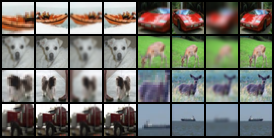

In [99]:
fixed_x, _ = next(iter(dataloader))
fixed_x = fixed_x.view(-1, 3, 32, 32)
save_image(fixed_x, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))

/Users/shubhamchandel/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


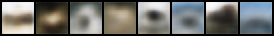

In [101]:
im = model(fixed_x)
save_image(im, 'real_image.png')
display(Image('real_image.png', width=1000, unconfined=True))